# TP4

#Imports

In [1]:
install.packages("xgboost")
library(xgboost)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [2]:
install.packages("randomForest")
library("randomForest")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

randomForest 4.7-1.2

Type rfNews() to see new features/changes/bug fixes.



In [3]:
install.packages("e1071")
library(e1071)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘proxy’




In [4]:
library(knitr)

In [5]:
load("/content/TP4.Rdata")
ls()

[1] "diag_test"  "diag_train" "esp_test"   "esp_train"  "RRL"

### Funciones Auxiliares K-Fold

In [6]:
k_fold_cv_xgboost <- function(data, column, folds, XGB.eta, XGB.nrounds, XGB.max.depth, num_folds = 5) {
  # Inicializar vector para almacenar la precisión de cada pliegue
  accuracies <- numeric(num_folds)

  for (i in 1:num_folds) {
      # Separar los datos de entrenamiento y validación
      test_indices <- which(folds == i, arr.ind = TRUE)
      test_data <- data[test_indices, ]
      train_data <- data[-test_indices, ]

      test_x <- test_data[, -ncol(test_data)]    # Todas las columnas menos la clase
      test_y <- test_data[[column]]

      m.xgb <- xgboost(
        data = as.matrix(train_data[, -ncol(train_data)]),
        label = as.integer(train_data[[column]]) - 1,
        objective = "binary:hinge",
        nrounds = XGB.nrounds,
        early_stopping_rounds = 1000,
        eta = XGB.eta,
        max.depth = XGB.max.depth,
        colsample_bytree = 1,
        verbose = 0,
        subsample = 1
      )

      test_pred <- predict(m.xgb, as.matrix(test_x))
      error <- mean(test_pred != (as.integer(test_y) - 1))
      accuracies[i] <- error
    }

    # Retornar la precisión promedio de todos los pliegues
    mean_accuracy <- mean(accuracies)
    return(mean_accuracy)
}

In [7]:
k_fold_cv_svm_RBF <- function(data, column, folds, c, gamma, num_folds = 5) {
  # Inicializar vector para almacenar la precisión de cada pliegue
  accuracies <- numeric(num_folds)

  for (i in 1:num_folds) {
      # Separar los datos de entrenamiento y validación
      test_indices <- which(folds == i, arr.ind = TRUE)
      test_data <- data[test_indices, ]
      train_data <- data[-test_indices, ]

      test_x <- test_data[, -ncol(test_data)]    # Todas las columnas menos la clase
      test_y <- test_data[[column]]

      svm_model <- svm(
        as.formula(paste(column, "~ .")),
        data = train_data,
        type = 'C-classification',
        kernel = "radial",
        cost = c,
        gamma = gamma
      )

      test_pred <- predict(svm_model, test_x)
      error <- mean(test_pred != test_y)
      accuracies[i] <- error
    }

    # Retornar la precisión promedio de todos los pliegues
    mean_accuracy <- mean(accuracies)
    return(mean_accuracy)
}

In [8]:
k_fold_cv_svm_polinomial <- function(data, column, folds, c, gamma, k, num_folds = 5) {
  # Inicializar vector para almacenar la precisión de cada pliegue
  accuracies <- numeric(num_folds)

  for (i in 1:num_folds) {
      # Separar los datos de entrenamiento y validación
      test_indices <- which(folds == i, arr.ind = TRUE)
      test_data <- data[test_indices, ]
      train_data <- data[-test_indices, ]

      test_x <- test_data[, -ncol(test_data)]    # Todas las columnas menos la clase
      test_y <- test_data[[column]]

      svm_model <- svm(
        as.formula(paste(column, "~ .")),
        data = train_data,
        type = 'C-classification',
        kernel = "polynomial",
        degree = k,
        cost = c,
        gamma = gamma
      )

      test_pred <- predict(svm_model, test_x)
      error <- mean(test_pred != test_y)
      accuracies[i] <- error
    }

    # Retornar la precisión promedio de todos los pliegues
    mean_accuracy <- mean(accuracies)
    return(mean_accuracy)
}

# Ej 1

## Espirales

### Predicción

In [9]:
maxProf <- 20
XGB.nrounds <- 200 #total de arboles/ciclos
XGB.eta <- 0.1 #learning rate, similar a redes

x.train <- as.matrix(esp_train[,1:2])
y.train <- esp_train[,3]

x.test <- as.matrix(esp_test[, 1:2])
y.test <- esp_test[, 3]

errors_train <- numeric(maxProf)
errors_test <- numeric(maxProf)

for (XGB.max.depth in 1:maxProf) {
  m.xgb <- xgboost(
    data = x.train,
    label = as.integer(y.train) - 1,
    objective = "binary:hinge",
    nrounds = XGB.nrounds,
    early_stopping_rounds = 1000,
    eta = XGB.eta,
    max.depth = XGB.max.depth,
    colsample_bytree = 1,
    verbose = 0,
    subsample = 1
  )

  train.pred <- predict(m.xgb, x.train)
  error <- mean(train.pred != (as.integer(y.train) - 1))
  errors_train[XGB.max.depth] <- error

  test.pred <- predict(m.xgb, x.test)
  error <- mean(test.pred != (as.integer(y.test) - 1))
  errors_test[XGB.max.depth] <- error
}

### Gráficas

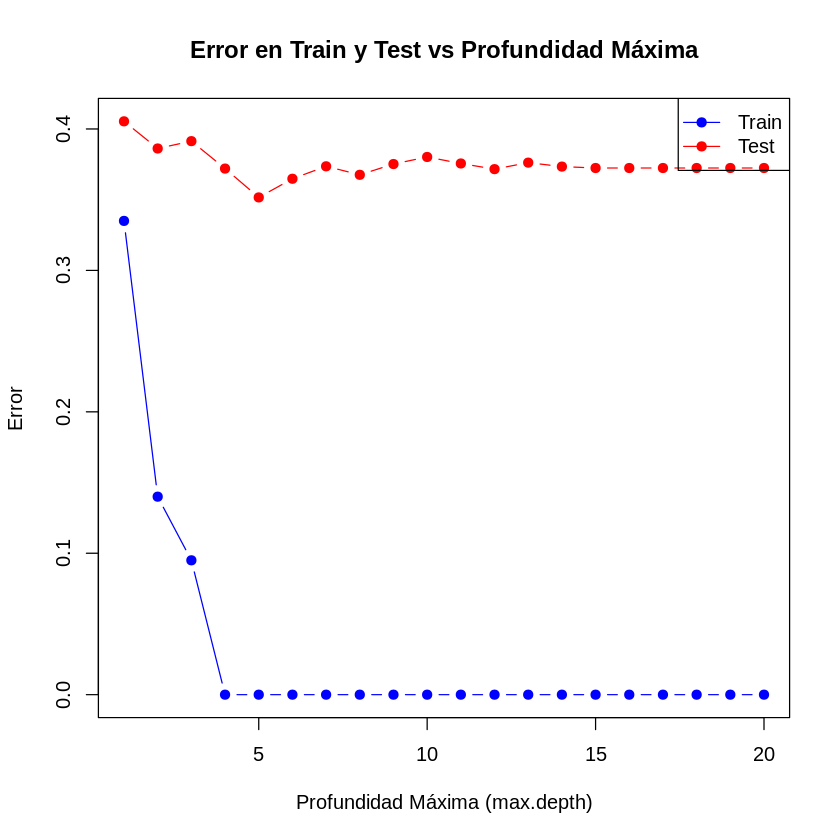

In [10]:
plot(
  1:maxProf,
  errors_train,
  type = "b",
  col = "blue",
  pch = 19,
  xlab = "Profundidad Máxima (max.depth)",
  ylab = "Error",
  main = "Error en Train y Test vs Profundidad Máxima",
  ylim = range(c(errors_train, errors_test))
)

lines(
  1:maxProf,
  errors_test,
  type = "b",
  col = "red",
  pch = 19
)

legend(
  "topright",
  legend = c("Train", "Test"),
  col = c("blue", "red"),
  pch = 19,
  lty = 1
)

## Diagonales

### Predicción

In [11]:
maxProf <- 20
XGB.nrounds <- 200 #total de arboles/ciclos
XGB.eta <- 0.1 #learning rate, similar a redes

x.train <- as.matrix(diag_train[,1:2])
y.train <- diag_train[,3]

x.test <- as.matrix(diag_test[, 1:2])
y.test <- diag_test[, 3]

errors_train <- numeric(maxProf)
errors_test <- numeric(maxProf)

for (XGB.max.depth in 1:maxProf) {
  m.xgb <- xgboost(
    data = x.train,
    label = as.integer(y.train) - 1,
    objective = "binary:hinge",
    nrounds = XGB.nrounds,
    early_stopping_rounds = 1000,
    eta = XGB.eta,
    max.depth = XGB.max.depth,
    colsample_bytree = 1,
    verbose = 0,
    subsample = 1
  )

  train.pred <- predict(m.xgb, x.train)
  error <- mean(train.pred != (as.integer(y.train) - 1))
  errors_train[XGB.max.depth] <- error

  test.pred <- predict(m.xgb, x.test)
  error <- mean(test.pred != (as.integer(y.test) - 1))
  errors_test[XGB.max.depth] <- error
}

### Gráficas

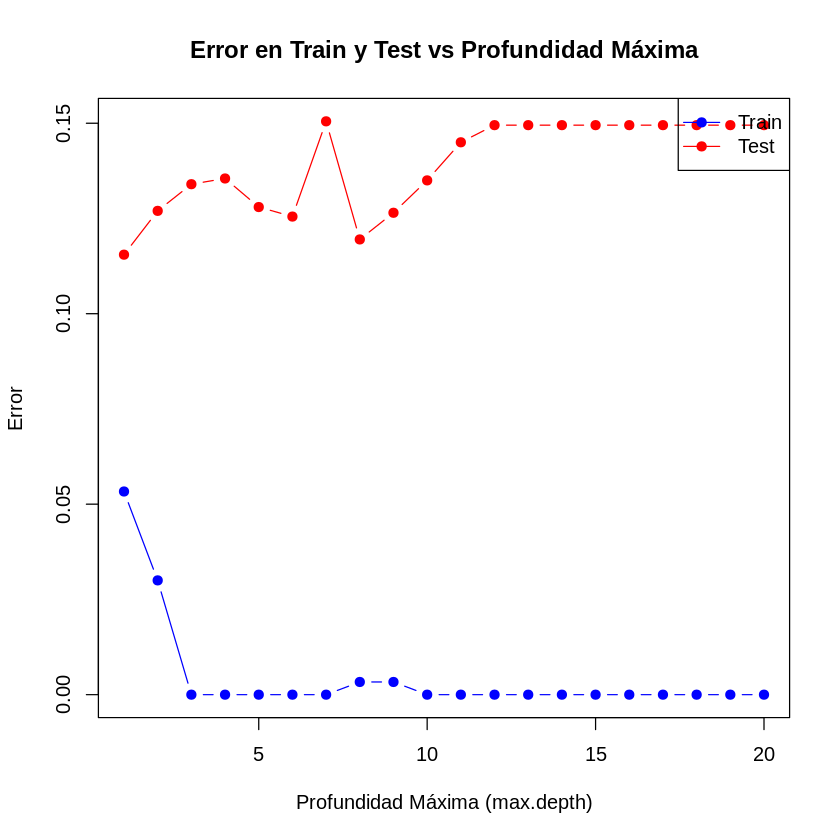

In [12]:
plot(
  1:maxProf,
  errors_train,
  type = "b",
  col = "blue",
  pch = 19,
  xlab = "Profundidad Máxima (max.depth)",
  ylab = "Error",
  main = "Error en Train y Test vs Profundidad Máxima",
  ylim = range(c(errors_train, errors_test))
)

lines(
  1:maxProf,
  errors_test,
  type = "b",
  col = "red",
  pch = 19
)

legend(
  "topright",
  legend = c("Train", "Test"),
  col = c("blue", "red"),
  pch = 19,
  lty = 1
)

# Ej 2

In [13]:
mtry_values <- floor((ncol(RRL)-1) * (1 / 2)^(0:6))
errors_avg <- c()
tree_count <- 1000
num_runs <- 5

for (mtry in mtry_values) {
  errors <- numeric(num_runs)

  for (i in 1:num_runs) {
    rf_model <- randomForest(
      Tipo ~ .,
      data = RRL,
      mtry = mtry,
      ntree = tree_count
    )

    errors[i] <- rf_model$err.rate[nrow(rf_model$err.rate), "OOB"]
  }
  errors_avg <- c(errors_avg, mean(errors))
}

In [14]:
for (i in 1:length(mtry_values)) {
  cat("Mtry", mtry_values[i], "had error", errors_avg[i], "\n")
}

Mtry 69 had error 0.04235127 
Mtry 34 had error 0.03926346 
Mtry 17 had error 0.03926346 
Mtry 8 had error 0.03909348 
Mtry 4 had error 0.03971671 
Mtry 2 had error 0.04164306 
Mtry 1 had error 0.04589235 


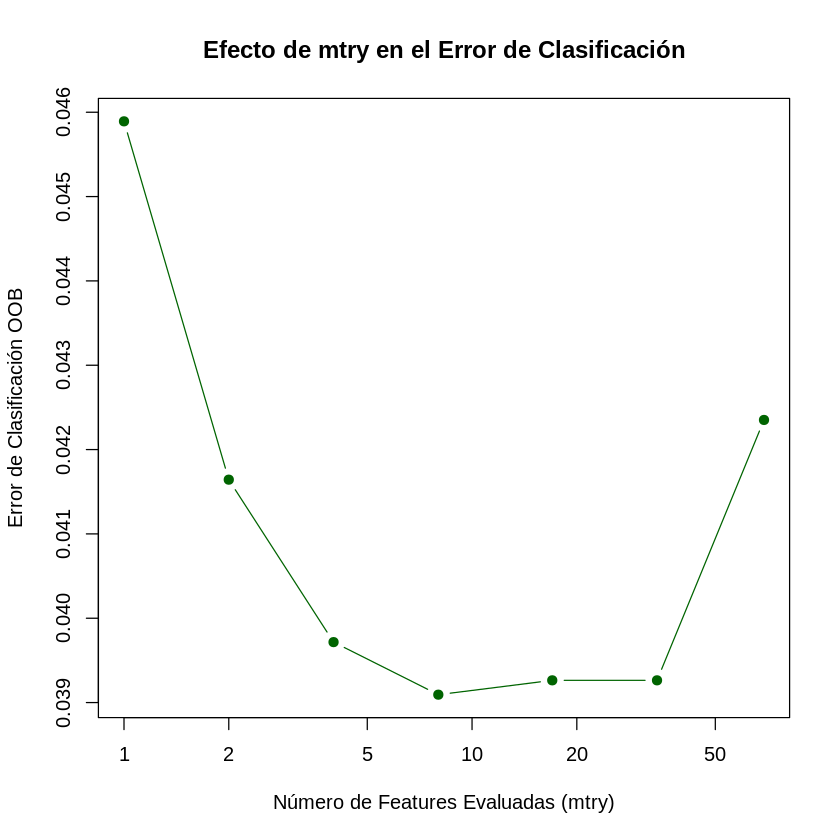

In [15]:
plot(
  mtry_values,
  errors_avg,
  type = "b",
  xlab = "Número de Features Evaluadas (mtry)",
  ylab = "Error de Clasificación OOB",
  main = "Efecto de mtry en el Error de Clasificación",
  col = "darkgreen",
  pch = 19,
  log = "x"
)


# Ej 3

## Cargar Dataset

Como primero tenemos que buscar los mejores parámetros para los distintos métodos y luego comparar los resultados entre ellos, decidí dividir el dataset en 80% para optimizacion de parámetros y entrenamiento de los mejores modelos y dejar el 20% restante para poder evaluarlos y compararlos con un conjunto de datos independiente. Con este problema hace que se complique porque tenemos pocos puntos, y dedicar el 20% (9 puntos) para testing nos deja con solo 40 puntos para entrenar.

In [ ]:
load("/content/lampone.Rdata")
#summary(lampone)
lampone <- lampone[sample(1:nrow(lampone)), ]
lampone <- lampone[, -c(1, 144)]

test_indices <- sample(1:nrow(lampone), size = (0.2 * nrow(lampone)))
test <- lampone[test_indices, ]
train <- lampone[-test_indices, ]

In [ ]:
nrow(test)
nrow(train)

[1] 9

[1] 40

## Optimizacion de parámetros

### Random Forest

Para RandomForest simplemente decidimos la profundidad según el OOB error mas bajo

In [ ]:
results <- data.frame(Mtry = numeric(), Error = numeric(), stringsAsFactors = FALSE)

mtry_values <- floor((ncol(train)-1) * (1 / 2)^(0:7))
errors_avg <- c()
tree_count <- 1000
num_runs <- 5

for (mtry in mtry_values) {
  errors <- numeric(num_runs)

  for (i in 1:num_runs) {
    rf_model <- randomForest(
      N_tipo ~ .,
      data=train,
      mtry = mtry,
      ntree = tree_count
    )

    errors[i] <- rf_model$err.rate[nrow(rf_model$err.rate), "OOB"]
  }
  errors_avg <- c(errors_avg, mean(errors))
  results <- rbind(results, data.frame(Mtry = mtry, Error = errors_avg[length(errors_avg)]))
}

In [ ]:
print(kable(results, format.args = list(scientific = FALSE), align = "r"))



| Mtry| Error|
|----:|-----:|
|  141| 0.175|
|   70| 0.160|
|   35| 0.150|
|   17| 0.120|
|    8| 0.120|
|    4| 0.150|
|    2| 0.170|
|    1| 0.200|


In [ ]:
min_error <- min(results$Error)
best_results_rf <- results[results$Error == min_error, ]
print(kable(best_results_rf, format.args = list(scientific = FALSE), align = "r"))



|   | Mtry| Error|
|:--|----:|-----:|
|4  |   17|  0.12|
|5  |    8|  0.12|


### XGBoosting

Para XGBoosting voy a utilizar 5-fold cross validation para estimar los errores.

In [ ]:
results <- data.frame(LearningRate = numeric(), Prof = integer(), Error = numeric(), stringsAsFactors = FALSE)

nrounds <- 500
learning_rates <- c(0.01, 0.05, 0.1, 0.3)
profs <- 1:20
num_folds <- 5
folds <- cut(seq(1, nrow(train)), breaks = num_folds, labels = FALSE)

for(i in 1:length(learning_rates)) {
  for(j in 1:length(profs)) {
    error_kfold <- k_fold_cv_xgboost(train, "N_tipo", folds, learning_rates[i], nrounds, profs[j], num_folds)
    results <- rbind(results, data.frame(LearningRate = learning_rates[i], Prof = profs[j], Error = error_kfold))
  }
}

In [ ]:
print(kable(results, format.args = list(scientific = FALSE), align = "r"))



| LearningRate| Prof| Error|
|------------:|----:|-----:|
|         0.01|    1| 0.200|
|         0.01|    2| 0.150|
|         0.01|    3| 0.200|
|         0.01|    4| 0.200|
|         0.01|    5| 0.200|
|         0.01|    6| 0.200|
|         0.01|    7| 0.200|
|         0.01|    8| 0.200|
|         0.01|    9| 0.200|
|         0.01|   10| 0.200|
|         0.01|   11| 0.200|
|         0.01|   12| 0.200|
|         0.01|   13| 0.200|
|         0.01|   14| 0.200|
|         0.01|   15| 0.200|
|         0.01|   16| 0.200|
|         0.01|   17| 0.200|
|         0.01|   18| 0.200|
|         0.01|   19| 0.200|
|         0.01|   20| 0.200|
|         0.05|    1| 0.175|
|         0.05|    2| 0.175|
|         0.05|    3| 0.200|
|         0.05|    4| 0.200|
|         0.05|    5| 0.200|
|         0.05|    6| 0.200|
|         0.05|    7| 0.200|
|         0.05|    8| 0.200|
|         0.05|    9| 0.200|
|         0.05|   10| 0.200|
|         0.05|   11| 0.200|
|         0.05|   12| 0.200|
|         0.

In [ ]:
min_error <- min(results$Error)
best_results_xgb <- results[results$Error == min_error, ]
print(kable(best_results_xgb, format.args = list(scientific = FALSE), align = "r"))



|   | LearningRate| Prof| Error|
|:--|------------:|----:|-----:|
|2  |         0.01|    2|  0.15|


### SVM - RBF

In [ ]:
results <- data.frame(Cost = numeric(),
                      Gamma = numeric(),
                      Error = numeric(),
                      stringsAsFactors = FALSE)

costs <- c(1, 10, 100, 1000, 10000, 100000)
gammas <- c(0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10)
num_folds <- 5
folds <- cut(seq(1, nrow(train)), breaks = num_folds, labels = FALSE)

for(i in 1:length(costs)) {
  for(j in 1:length(gammas)) {
    suppressWarnings(error_kfold <- k_fold_cv_svm_RBF(train, "N_tipo", folds, costs[i], gammas[j], num_folds))
    results <- rbind(results, data.frame(Cost = costs[i], Gamma = gammas[j], Error = error_kfold))
  }
}

In [ ]:
print(kable(results, format.args = list(scientific = FALSE), align = "r"))



|   Cost|      Gamma| Error|
|------:|----------:|-----:|
|      1|  0.0000001| 0.575|
|      1|  0.0000010| 0.575|
|      1|  0.0000100| 0.400|
|      1|  0.0001000| 0.200|
|      1|  0.0010000| 0.175|
|      1|  0.0100000| 0.525|
|      1|  0.1000000| 0.525|
|      1|  1.0000000| 0.600|
|      1| 10.0000000| 0.475|
|     10|  0.0000001| 0.575|
|     10|  0.0000010| 0.500|
|     10|  0.0000100| 0.125|
|     10|  0.0001000| 0.275|
|     10|  0.0010000| 0.250|
|     10|  0.0100000| 0.525|
|     10|  0.1000000| 0.525|
|     10|  1.0000000| 0.600|
|     10| 10.0000000| 0.475|
|    100|  0.0000001| 0.475|
|    100|  0.0000010| 0.250|
|    100|  0.0000100| 0.200|
|    100|  0.0001000| 0.325|
|    100|  0.0010000| 0.225|
|    100|  0.0100000| 0.525|
|    100|  0.1000000| 0.525|
|    100|  1.0000000| 0.600|
|    100| 10.0000000| 0.475|
|   1000|  0.0000001| 0.275|
|   1000|  0.0000010| 0.175|
|   1000|  0.0000100| 0.175|
|   1000|  0.0001000| 0.275|
|   1000|  0.0010000| 0.225|
|   1000|  0

In [ ]:
min_error <- min(results$Error)
best_results_svmrbf <- results[results$Error == min_error, ]
print(kable(best_results_svmrbf, format.args = list(scientific = FALSE), align = "r"))



|   | Cost|   Gamma| Error|
|:--|----:|-------:|-----:|
|12 |   10| 0.00001| 0.125|


### SVM - Polinomial

In [ ]:
results <- data.frame(Cost = numeric(), Gamma = numeric(), Degree = integer(), Error = numeric(), stringsAsFactors = FALSE)

costs <- c(1, 10, 100, 1000, 10000, 100000)
gammas <- c(0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10)
degrees <- 1:5
num_folds <- 5
folds <- cut(seq(1, nrow(train)), breaks = num_folds, labels = FALSE)

for(i in 1:length(costs)) {
  for(j in 1:length(gammas)) {
    for(k in 1:length(degrees)) {
      suppressWarnings(error_kfold <- k_fold_cv_svm_polinomial(train, "N_tipo", folds, costs[i], gammas[j], degrees[k], num_folds))
      results <- rbind(results, data.frame(Cost = costs[i], Gamma = gammas[j], Degree = degrees[k], Error = error_kfold))
    }
  }
}

In [ ]:
print(kable(results, format.args = list(scientific = FALSE), align = "r"))



|   Cost|      Gamma| Degree| Error|
|------:|----------:|------:|-----:|
|      1|  0.0000001|      1| 0.575|
|      1|  0.0000001|      2| 0.525|
|      1|  0.0000001|      3| 0.475|
|      1|  0.0000001|      4| 0.525|
|      1|  0.0000001|      5| 0.550|
|      1|  0.0000010|      1| 0.575|
|      1|  0.0000010|      2| 0.525|
|      1|  0.0000010|      3| 0.475|
|      1|  0.0000010|      4| 0.525|
|      1|  0.0000010|      5| 0.550|
|      1|  0.0000100|      1| 0.600|
|      1|  0.0000100|      2| 0.300|
|      1|  0.0000100|      3| 0.225|
|      1|  0.0000100|      4| 0.150|
|      1|  0.0000100|      5| 0.200|
|      1|  0.0001000|      1| 0.275|
|      1|  0.0001000|      2| 0.175|
|      1|  0.0001000|      3| 0.225|
|      1|  0.0001000|      4| 0.200|
|      1|  0.0001000|      5| 0.200|
|      1|  0.0010000|      1| 0.350|
|      1|  0.0010000|      2| 0.150|
|      1|  0.0010000|      3| 0.225|
|      1|  0.0010000|      4| 0.200|
|      1|  0.0010000|      5| 0.200|

In [ ]:
min_error <- min(results$Error)
best_results_svmp <- results[results$Error == min_error, ]
print(kable(best_results_svmp, format.args = list(scientific = FALSE), align = "r"))



|    |   Cost|     Gamma| Degree| Error|
|:---|------:|---------:|------:|-----:|
|14  |      1|  0.000010|      4|  0.15|
|22  |      1|  0.001000|      2|  0.15|
|27  |      1|  0.010000|      2|  0.15|
|29  |      1|  0.010000|      4|  0.15|
|31  |      1|  0.100000|      1|  0.15|
|32  |      1|  0.100000|      2|  0.15|
|37  |      1|  1.000000|      2|  0.15|
|42  |      1| 10.000000|      2|  0.15|
|67  |     10|  0.001000|      2|  0.15|
|71  |     10|  0.010000|      1|  0.15|
|72  |     10|  0.010000|      2|  0.15|
|74  |     10|  0.010000|      4|  0.15|
|77  |     10|  0.100000|      2|  0.15|
|82  |     10|  1.000000|      2|  0.15|
|87  |     10| 10.000000|      2|  0.15|
|103 |    100|  0.000010|      3|  0.15|
|107 |    100|  0.000100|      2|  0.15|
|111 |    100|  0.001000|      1|  0.15|
|112 |    100|  0.001000|      2|  0.15|
|117 |    100|  0.010000|      2|  0.15|
|119 |    100|  0.010000|      4|  0.15|
|122 |    100|  0.100000|      2|  0.15|
|127 |    100|

## Comparación

Ahora corramos los distintos métodos con los mejores parámetros obtenidos y con todo el conjunto de train y comparemoslos entre ellos evaluando en test.

### RandomForest

In [ ]:
final_results_rf <- data.frame(Mtry = numeric(),
                               Train_Error = numeric(),
                               Test_Error = numeric(),
                               stringsAsFactors = FALSE)
tree_count <- 1000

for (i in 1:nrow(best_results_rf)) {
  mtry <- best_results_rf$Mtry[i]

  rf_model <- randomForest(
    N_tipo ~ .,
    data=train,
    mtry = mtry,
    ntree = tree_count
  )

  train_pred_rf <- predict(rf_model, train[, -ncol(train)])
  train_error_rf <- mean(train_pred_rf != train$N_tipo)

  test_pred_rf <- predict(rf_model, test[, -ncol(test)])
  test_error_rf <- mean(test_pred_rf != test$N_tipo)

  final_results_rf <- rbind(final_results_rf, data.frame(Mtry = mtry, Train_Error = train_error_rf, Test_Error = test_error_rf))
}

In [ ]:
print(kable(final_results_rf, format.args = list(scientific = FALSE), align = "r"))



| Mtry| Train_Error| Test_Error|
|----:|-----------:|----------:|
|   17|           0|          0|
|    8|           0|          0|


### XGBoost

In [ ]:
final_results_xgb <- data.frame(LearningRate = numeric(), Prof = integer(), Train_Error = numeric(), Test_Error = numeric(), stringsAsFactors = FALSE)

nrounds <- 500

for (i in 1:nrow(best_results_xgb)) {
  # Obtener los parámetros de la fila actual
  best_lr <- best_results_xgb$LearningRate[i]
  best_max_depth <- best_results_xgb$Prof[i]

  # Entrenar el modelo XGBoost con los mejores parámetros
  m.xgb <- xgboost(
    data = as.matrix(train[, -ncol(train)]),
    label = as.integer(train$N_tipo) - 1,
    objective = "binary:hinge",
    nrounds = nrounds,
    early_stopping_rounds = 1000,
    eta = best_lr,
    max.depth = best_max_depth,
    colsample_bytree = 1,
    verbose = 0,
    subsample = 1
  )

  train_pred_xgb <- predict(m.xgb, as.matrix(train[, -ncol(train)]))
  train_error_xgb <- mean(train_pred_xgb != (as.integer(train$N_tipo) - 1))

  test_pred_xgb <- predict(m.xgb, as.matrix(test[, -ncol(test)]))
  test_error_xgb <- mean(test_pred_xgb != (as.integer(test$N_tipo) - 1))

  final_results_xgb <- rbind(final_results_xgb, data.frame(LearningRate = best_lr,
                                                           Prof = best_max_depth,
                                                           Train_Error = train_error_xgb,
                                                           Test_Error = test_error_xgb))
}

In [ ]:
print(kable(final_results_xgb, format.args = list(scientific = FALSE), align = "r"))



| LearningRate| Prof| Train_Error| Test_Error|
|------------:|----:|-----------:|----------:|
|         0.01|    2|           0|  0.1111111|


### SVM RBF

In [ ]:
final_results_svmrbf <- data.frame(Cost = numeric(), Gamma = numeric(), Train_Error = numeric(), Test_Error = numeric(), stringsAsFactors = FALSE)

for (i in 1:nrow(best_results_svmrbf)) {
  # Obtener los parámetros de la fila actual
  best_cost <- best_results_svmrbf$Cost[i]
  best_gamma <- best_results_svmrbf$Gamma[i]

  # Entrenar el modelo SVM con los mejores parámetros
  suppressWarnings(svm_model <- svm(
    N_tipo ~ .,
    data = train,
    type = 'C-classification',
    kernel = "radial",
    cost = best_cost,
    gamma = best_gamma
  ))

  train_pred_svmrbf <- predict(svm_model, train[, -ncol(train)])
  train_error_svmrbf <- mean(train_pred_svmrbf != train$N_tipo)

  test_pred_svmrbf <- predict(svm_model, test[, -ncol(test)])
  test_error_svmrbf <- mean(test_pred_svmrbf != test$N_tipo)

  # Guardar los resultados en el dataframe
  final_results_svmrbf <- rbind(final_results_svmrbf, data.frame(Cost = best_cost, Gamma = best_gamma, Train_Error = train_error_svmrbf, Test_Error = test_error_svmrbf))
}


In [ ]:
print(kable(final_results_svmrbf, format.args = list(scientific = FALSE), align = "r"))



| Cost|   Gamma| Train_Error| Test_Error|
|----:|-------:|-----------:|----------:|
|   10| 0.00001|       0.125|  0.4444444|


### SVM Polinomial

In [ ]:
final_results_svmp <- data.frame(Cost = numeric(), Gamma = numeric(), Degree = integer(), Train_Error = numeric(), Test_Error = numeric(), stringsAsFactors = FALSE)

for (i in 1:nrow(best_results_svmp)) {
  best_cost <- best_results_svmp$Cost[i]
  best_gamma <- best_results_svmp$Gamma[i]
  best_degree <- best_results_svmp$Degree[i]

  suppressWarnings(svm_model <- svm(
    N_tipo ~ .,
    data = train,
    type = 'C-classification',
    kernel = "polynomial",
    degree = best_degree,
    cost = best_cost,
    gamma = best_gamma
  ))

  train_pred_svmpol <- predict(svm_model, train[, -ncol(train)])
  train_error_svmpol <- mean(train_pred_svmpol != train$N_tipo)

  test_pred_svmpol <- predict(svm_model, test[, -ncol(test)])
  test_error_svmpol <- mean(test_pred_svmpol != test$N_tipo)

  final_results_svmp <- rbind(final_results_svmp, data.frame(Cost = best_cost, Gamma = best_gamma, Degree = best_degree, Train_Error = train_error_svmpol, Test_Error = test_error_svmpol))
}

In [ ]:
print(kable(final_results_svmp, format.args = list(scientific = FALSE), align = "r"))



|   Cost|     Gamma| Degree| Train_Error| Test_Error|
|------:|---------:|------:|-----------:|----------:|
|      1|  0.000010|      4|       0.125|  0.4444444|
|      1|  0.001000|      2|       0.000|  0.1111111|
|      1|  0.010000|      2|       0.000|  0.1111111|
|      1|  0.010000|      4|       0.000|  0.2222222|
|      1|  0.100000|      1|       0.025|  0.1111111|
|      1|  0.100000|      2|       0.000|  0.1111111|
|      1|  1.000000|      2|       0.000|  0.1111111|
|      1| 10.000000|      2|       0.000|  0.1111111|
|     10|  0.001000|      2|       0.000|  0.1111111|
|     10|  0.010000|      1|       0.025|  0.1111111|
|     10|  0.010000|      2|       0.000|  0.1111111|
|     10|  0.010000|      4|       0.000|  0.2222222|
|     10|  0.100000|      2|       0.000|  0.1111111|
|     10|  1.000000|      2|       0.000|  0.1111111|
|     10| 10.000000|      2|       0.000|  0.1111111|
|    100|  0.000010|      3|       0.025|  0.0000000|
|    100|  0.000100|      

### Gráfica

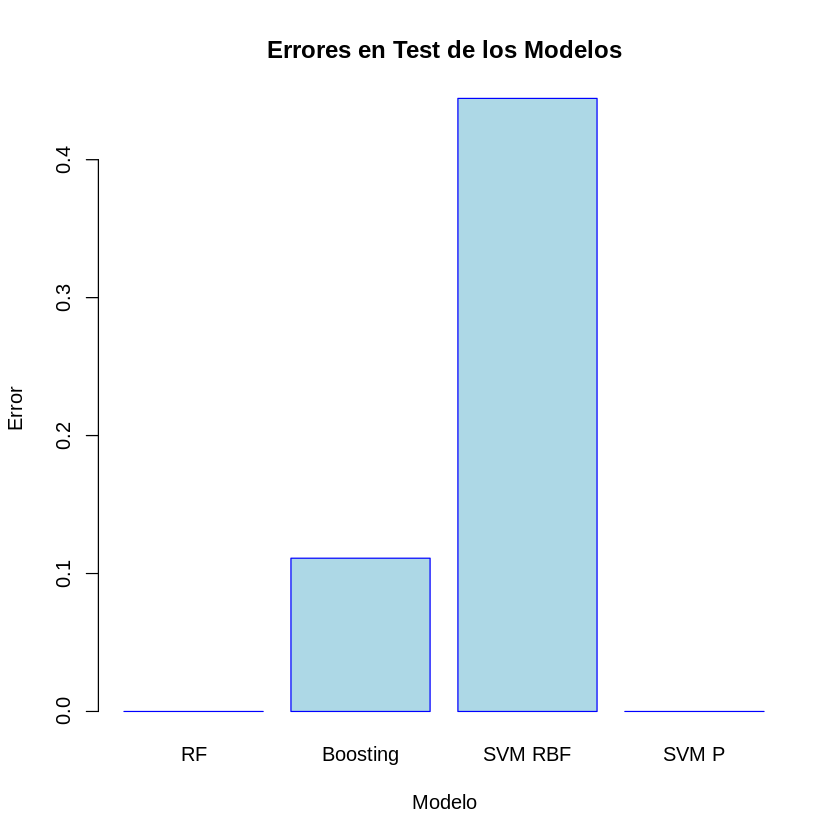

In [ ]:
modelos <- c("RF", "Boosting", "SVM RBF", "SVM P")
errores_test <- c(min(final_results_rf$Test_Error), min(final_results_xgb$Test_Error), min(final_results_svmrbf$Test_Error), min(final_results_svmp$Test_Error))

barplot(height = errores_test,
        names.arg = modelos,
        xlab = "Modelo",
        ylab = "Error",
        col = "lightblue",
        border = "blue",
        main = "Errores en Test de los Modelos")

# Ej 4

## Cargar Dataset

In [18]:
RRL <- RRL[sample(1:nrow(RRL)), ]

test_indices <- sample(1:nrow(RRL), size = (0.2 * nrow(RRL)))
test <- RRL[test_indices, ]
train <- RRL[-test_indices, ]

In [19]:
nrow(test)
nrow(train)

[1] 1412

[1] 5648

## Optimizacion de parámetros

### Random Forest

In [ ]:
results_rrl_rf <- data.frame(Mtry = numeric(), Error = numeric(), stringsAsFactors = FALSE)

mtry_values <- floor((ncol(train)-1) * (1 / 2)^(0:6))
errors_avg <- c()
tree_count <- 1000
num_runs <- 5

for (mtry in mtry_values) {
  errors <- numeric(num_runs)

  for (i in 1:num_runs) {
    rf_model <- randomForest(
      Tipo ~ .,
      data=train,
      mtry = mtry,
      ntree = tree_count
    )

    errors[i] <- rf_model$err.rate[nrow(rf_model$err.rate), "OOB"]
  }
  errors_avg <- c(errors_avg, mean(errors))
  results_rrl_rf <- rbind(results_rrl_rf, data.frame(Mtry = mtry, Error = errors_avg[length(errors_avg)]))
}

In [6]:
load("/content/results_rrl_rf.RData")

In [7]:
print(kable(results_rrl_rf, format.args = list(scientific = FALSE), align = "r"))



| Mtry|     Error|
|----:|---------:|
|   69| 0.0458924|
|   34| 0.0405453|
|   17| 0.0400496|
|    8| 0.0396955|
|    4| 0.0403683|
|    2| 0.0423159|
|    1| 0.0461048|


In [8]:
min_error <- min(results_rrl_rf$Error)
best_results_rf <- results_rrl_rf[results_rrl_rf$Error == min_error, ]
print(kable(best_results_rf, format.args = list(scientific = FALSE), align = "r"))



|   | Mtry|     Error|
|:--|----:|---------:|
|4  |    8| 0.0396955|


### XGBoosting

In [ ]:
results_rrl_xgb <- data.frame(LearningRate = numeric(), Prof = integer(), Error = numeric(), stringsAsFactors = FALSE)

nrounds <- 1000
learning_rates <- c(0.01, 0.05, 0.1, 0.3)
profs <- 1:20
num_folds <- 5
folds <- cut(seq(1, nrow(train)), breaks = num_folds, labels = FALSE)

for(i in 1:length(learning_rates)) {
  for(j in 1:length(profs)) {
    error_kfold <- k_fold_cv_xgboost(train, "Tipo", folds, learning_rates[i], nrounds, profs[j], num_folds)
    results_rrl_xgb <- rbind(results_rrl_xgb, data.frame(LearningRate = learning_rates[i], Prof = profs[j], Error = error_kfold))
  }
}

In [9]:
load("/content/results_rrl_xgb.RData")

In [10]:
print(kable(results_rrl_xgb, format.args = list(scientific = FALSE), align = "r"))



| LearningRate| Prof|     Error|
|------------:|----:|---------:|
|         0.01|    1| 0.0566547|
|         0.01|    2| 0.0501043|
|         0.01|    3| 0.0410751|
|         0.01|    4| 0.0423136|
|         0.01|    5| 0.0433760|
|         0.01|    6| 0.0479797|
|         0.01|    7| 0.0486881|
|         0.01|    8| 0.0515207|
|         0.01|    9| 0.0531141|
|         0.01|   10| 0.0529370|
|         0.01|   11| 0.0536443|
|         0.01|   12| 0.0541759|
|         0.01|   13| 0.0552379|
|         0.01|   14| 0.0548840|
|         0.01|   15| 0.0552393|
|         0.01|   16| 0.0555926|
|         0.01|   17| 0.0555926|
|         0.01|   18| 0.0555932|
|         0.01|   19| 0.0555923|
|         0.01|   20| 0.0548845|
|         0.05|    1| 0.0449688|
|         0.05|    2| 0.0446157|
|         0.05|    3| 0.0423145|
|         0.05|    4| 0.0428455|
|         0.05|    5| 0.0424909|
|         0.05|    6| 0.0470949|
|         0.05|    7| 0.0497503|
|         0.05|    8| 0.0492192|
|       

In [11]:
min_error <- min(results_rrl_xgb$Error)
best_results_xgb <- results_rrl_xgb[results_rrl_xgb$Error == min_error, ]
print(kable(best_results_xgb, format.args = list(scientific = FALSE), align = "r"))



|   | LearningRate| Prof|     Error|
|:--|------------:|----:|---------:|
|3  |         0.01|    3| 0.0410751|


### SVM - RBF

In [ ]:
results_rrl_svmrbf <- data.frame(Cost = numeric(),
                      Gamma = numeric(),
                      Error = numeric(),
                      stringsAsFactors = FALSE)

costs <- c(1, 10, 100, 1000, 10000, 100000)
gammas <- c(0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10)
num_folds <- 5
folds <- cut(seq(1, nrow(train)), breaks = num_folds, labels = FALSE)

for(i in 1:length(costs)) {
  for(j in 1:length(gammas)) {
    suppressWarnings(error_kfold <- k_fold_cv_svm_RBF(train, "Tipo", folds, costs[i], gammas[j], num_folds))
    results_rrl_svmrbf <- rbind(results_rrl_svmrbf, data.frame(Cost = costs[i], Gamma = gammas[j], Error = error_kfold))
  }
}

In [12]:
load("/content/results_rrl_svmrbf.RData")

In [13]:
print(kable(results_rrl_svmrbf, format.args = list(scientific = FALSE), align = "r"))



|   Cost|      Gamma|     Error|
|------:|----------:|---------:|
|      1|  0.0000001| 0.5070765|
|      1|  0.0000010| 0.5070765|
|      1|  0.0000100| 0.1873057|
|      1|  0.0001000| 0.1345612|
|      1|  0.0010000| 0.1196899|
|      1|  0.0100000| 0.0926005|
|      1|  0.1000000| 0.1113676|
|      1|  1.0000000| 0.5068994|
|      1| 10.0000000| 0.5070765|
|     10|  0.0000001| 0.5070765|
|     10|  0.0000010| 0.1871284|
|     10|  0.0000100| 0.1340304|
|     10|  0.0001000| 0.1260641|
|     10|  0.0010000| 0.0980893|
|     10|  0.0100000| 0.0848104|
|     10|  0.1000000| 0.1101285|
|     10|  1.0000000| 0.5067222|
|     10| 10.0000000| 0.5070765|
|    100|  0.0000001| 0.1871284|
|    100|  0.0000010| 0.1340304|
|    100|  0.0000100| 0.1265954|
|    100|  0.0001000| 0.1092435|
|    100|  0.0010000| 0.0879972|
|    100|  0.0100000| 0.1019841|
|    100|  0.1000000| 0.1101285|
|    100|  1.0000000| 0.5067222|
|    100| 10.0000000| 0.5070765|
|   1000|  0.0000001| 0.1340304|
|   1000

In [14]:
min_error <- min(results_rrl_svmrbf$Error)
best_results_svmrbf <- results_rrl_svmrbf[results_rrl_svmrbf$Error == min_error, ]
print(kable(best_results_svmrbf, format.args = list(scientific = FALSE), align = "r"))



|   | Cost| Gamma|     Error|
|:--|----:|-----:|---------:|
|32 | 1000| 0.001| 0.0844553|


### SVM - Polinomial

In [ ]:
results_rrl_svmp <- data.frame(Cost = numeric(), Gamma = numeric(), Degree = integer(), Error = numeric(), stringsAsFactors = FALSE)

costs <- c(1, 10, 100, 1000, 10000, 100000)
gammas <- c(0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10)
degrees <- 1:5
num_folds <- 5
folds <- cut(seq(1, nrow(train)), breaks = num_folds, labels = FALSE)

for(i in 1:length(costs)) {
  for(j in 1:length(gammas)) {
    for(k in 1:length(degrees)) {
      suppressWarnings(error_kfold <- k_fold_cv_svm_polinomial(train, "Tipo", folds, costs[i], gammas[j], degrees[k], num_folds))
      results_rrl_svmp <- rbind(results_rrl_svmp, data.frame(Cost = costs[i], Gamma = gammas[j], Degree = degrees[k], Error = error_kfold))
    }
  }
}

In [15]:
load("/content/results_rrl_svmp.RData")

In [16]:
print(kable(results_rrl_svmp, format.args = list(scientific = FALSE), align = "r"))



|   Cost|      Gamma| Degree|     Error|
|------:|----------:|------:|---------:|
|      1|  0.0000001|      1| 0.5070765|
|      1|  0.0000001|      2| 0.5070765|
|      1|  0.0000001|      3| 0.5070765|
|      1|  0.0000001|      4| 0.5070765|
|      1|  0.0000001|      5| 0.5070765|
|      1|  0.0000010|      1| 0.5070765|
|      1|  0.0000010|      2| 0.5070765|
|      1|  0.0000010|      3| 0.5070765|
|      1|  0.0000010|      4| 0.5070765|
|      1|  0.0000010|      5| 0.5070765|
|      1|  0.0000100|      1| 0.5058365|
|      1|  0.0000100|      2| 0.5070765|
|      1|  0.0000100|      3| 0.5070765|
|      1|  0.0000100|      4| 0.5070765|
|      1|  0.0000100|      5| 0.5070765|
|      1|  0.0001000|      1| 0.1489032|
|      1|  0.0001000|      2| 0.5065452|
|      1|  0.0001000|      3| 0.5067224|
|      1|  0.0001000|      4| 0.5068994|
|      1|  0.0001000|      5| 0.5068994|
|      1|  0.0010000|      1| 0.1281883|
|      1|  0.0010000|      2| 0.4851255|
|      1|  0.0

In [17]:
min_error <- min(results_rrl_svmp$Error)
best_results_svmp <- results_rrl_svmp [results_rrl_svmp$Error == min_error, ]
print(kable(best_results_svmp, format.args = list(scientific = FALSE), align = "r"))



|   | Cost| Gamma| Degree|     Error|
|:--|----:|-----:|------:|---------:|
|86 |   10|    10|      1| 0.0936616|


## Comparación

Ahora corramos los distintos métodos con los mejores parámetros obtenidos y con todo el conjunto de train y comparemoslos entre ellos evaluando en test.

### RandomForest

In [20]:
final_results_rf <- data.frame(Mtry = numeric(),
                               Train_Error = numeric(),
                               Test_Error = numeric(),
                               stringsAsFactors = FALSE)
tree_count <- 1000

for (i in 1:nrow(best_results_rf)) {
  mtry <- best_results_rf$Mtry[i]

  rf_model <- randomForest(
    Tipo ~ .,
    data=train,
    mtry = mtry,
    ntree = tree_count
  )

  train_pred_rf <- predict(rf_model, train[, -ncol(train)])
  train_error_rf <- mean(train_pred_rf != train$Tipo)

  test_pred_rf <- predict(rf_model, test[, -ncol(test)])
  test_error_rf <- mean(test_pred_rf != test$Tipo)

  final_results_rf <- rbind(final_results_rf, data.frame(Mtry = mtry, Train_Error = train_error_rf, Test_Error = test_error_rf))
}

In [21]:
print(kable(final_results_rf, format.args = list(scientific = FALSE), align = "r"))



| Mtry| Train_Error| Test_Error|
|----:|-----------:|----------:|
|    8|           0|   0.036119|


### XGBoost

In [22]:
final_results_xgb <- data.frame(LearningRate = numeric(), Prof = integer(), Train_Error = numeric(), Test_Error = numeric(), stringsAsFactors = FALSE)

nrounds <- 1000

for (i in 1:nrow(best_results_xgb)) {
  # Obtener los parámetros de la fila actual
  best_lr <- best_results_xgb$LearningRate[i]
  best_max_depth <- best_results_xgb$Prof[i]

  # Entrenar el modelo XGBoost con los mejores parámetros
  m.xgb <- xgboost(
    data = as.matrix(train[, -ncol(train)]),
    label = as.integer(train$Tipo) - 1,
    objective = "binary:hinge",
    nrounds = nrounds,
    early_stopping_rounds = 1000,
    eta = best_lr,
    max.depth = best_max_depth,
    colsample_bytree = 1,
    verbose = 0,
    subsample = 1
  )

  train_pred_xgb <- predict(m.xgb, as.matrix(train[, -ncol(train)]))
  train_error_xgb <- mean(train_pred_xgb != (as.integer(train$Tipo) - 1))

  test_pred_xgb <- predict(m.xgb, as.matrix(test[, -ncol(test)]))
  test_error_xgb <- mean(test_pred_xgb != (as.integer(test$Tipo) - 1))

  final_results_xgb <- rbind(final_results_xgb, data.frame(LearningRate = best_lr,
                                                           Prof = best_max_depth,
                                                           Train_Error = train_error_xgb,
                                                           Test_Error = test_error_xgb))
}

In [23]:
print(kable(final_results_xgb, format.args = list(scientific = FALSE), align = "r"))



| LearningRate| Prof| Train_Error| Test_Error|
|------------:|----:|-----------:|----------:|
|         0.01|    3|   0.0194759|  0.0354108|


### SVM RBF

In [24]:
final_results_svmrbf <- data.frame(Cost = numeric(), Gamma = numeric(), Train_Error = numeric(), Test_Error = numeric(), stringsAsFactors = FALSE)

for (i in 1:nrow(best_results_svmrbf)) {
  # Obtener los parámetros de la fila actual
  best_cost <- best_results_svmrbf$Cost[i]
  best_gamma <- best_results_svmrbf$Gamma[i]

  # Entrenar el modelo SVM con los mejores parámetros
  suppressWarnings(svm_model <- svm(
    Tipo ~ .,
    data = train,
    type = 'C-classification',
    kernel = "radial",
    cost = best_cost,
    gamma = best_gamma
  ))

  train_pred_svmrbf <- predict(svm_model, train[, -ncol(train)])
  train_error_svmrbf <- mean(train_pred_svmrbf != train$Tipo)

  test_pred_svmrbf <- predict(svm_model, test[, -ncol(test)])
  test_error_svmrbf <- mean(test_pred_svmrbf != test$Tipo)

  # Guardar los resultados en el dataframe
  final_results_svmrbf <- rbind(final_results_svmrbf, data.frame(Cost = best_cost, Gamma = best_gamma, Train_Error = train_error_svmrbf, Test_Error = test_error_svmrbf))
}


In [25]:
print(kable(final_results_svmrbf, format.args = list(scientific = FALSE), align = "r"))



| Cost| Gamma| Train_Error| Test_Error|
|----:|-----:|-----------:|----------:|
| 1000| 0.001|   0.0435552|  0.0715297|


### SVM Polinomial

In [26]:
final_results_svmp <- data.frame(Cost = numeric(), Gamma = numeric(), Degree = integer(), Train_Error = numeric(), Test_Error = numeric(), stringsAsFactors = FALSE)

for (i in 1:nrow(best_results_svmp)) {
  best_cost <- best_results_svmp$Cost[i]
  best_gamma <- best_results_svmp$Gamma[i]
  best_degree <- best_results_svmp$Degree[i]

  suppressWarnings(svm_model <- svm(
    Tipo ~ .,
    data = train,
    type = 'C-classification',
    kernel = "polynomial",
    degree = best_degree,
    cost = best_cost,
    gamma = best_gamma
  ))

  train_pred_svmpol <- predict(svm_model, train[, -ncol(train)])
  train_error_svmpol <- mean(train_pred_svmpol != train$Tipo)

  test_pred_svmpol <- predict(svm_model, test[, -ncol(test)])
  test_error_svmpol <- mean(test_pred_svmpol != test$Tipo)

  final_results_svmp <- rbind(final_results_svmp, data.frame(Cost = best_cost, Gamma = best_gamma, Degree = best_degree, Train_Error = train_error_svmpol, Test_Error = test_error_svmpol))
}

In [27]:
print(kable(final_results_svmp, format.args = list(scientific = FALSE), align = "r"))



| Cost| Gamma| Degree| Train_Error| Test_Error|
|----:|-----:|------:|-----------:|----------:|
|   10|    10|      1|   0.0949008|  0.0871105|


### Gráfica

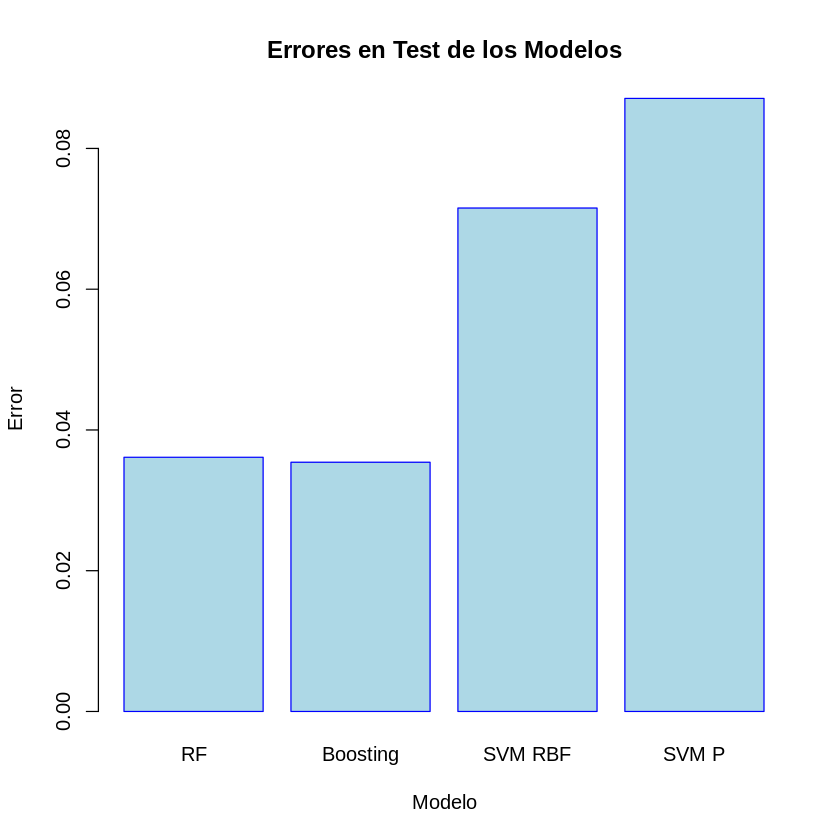

In [28]:
modelos <- c("RF", "Boosting", "SVM RBF", "SVM P")
errores_test <- c(min(final_results_rf$Test_Error), min(final_results_xgb$Test_Error), min(final_results_svmrbf$Test_Error), min(final_results_svmp$Test_Error))

barplot(height = errores_test,
        names.arg = modelos,
        xlab = "Modelo",
        ylab = "Error",
        col = "lightblue",
        border = "blue",
        main = "Errores en Test de los Modelos")